# Get 2 the Core Data Mungeing

https://portal.unearthed.solutions/competitions/get-2-the-core

Core pics have up to 12 rows (may have two trays photographed together).

Pics have tray(s) as main feature, sign as second feature

Coordinates are: 

X1 from Left
Y1 from bottom

In [718]:
#for debugging use:
#import pdb; pdb.set_trace()

In [719]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [720]:
from math import atan, degrees
import json, pdb
import shutil
from PIL import ImageDraw, ImageFont
from pathlib import PosixPath
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

from fastai.conv_learner import *
from fastai.dataset import *

In [721]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [722]:
#only need to run these once
SAVE_PADDED_FILES = False
SAVE_RESIZED_FILES = False
SAVE_RESIZED_MASKED = False

In [723]:
PATH = Path('data')
IMG_PATH = PATH/'data/train/'

In [724]:
RESIZE_DIM = 224

In [725]:
train = pd.read_csv(PATH/'train_with_labels_v3.csv')
#create an ID column
train['id'] = train.index
train.head()

,OutputID,row_1_X_1,row_1_Y_1,row_1_X_2,row_1_Y_2,row_1_X_3,row_1_Y_3,row_1_X_4,row_1_Y_4,row_2_X_1,...,row_11_Y_4,Type_0,Type_1,Type_2,Type_3,Type_4,Type_5,ImageLocation,MaskLocation,id
0,Image376_1TPP_4R_PL2.jpg,100,2587,3527,2619,3530,2353,100,2327,100,...,0,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",0
1,Image208_1TPP_3R_MT.jpg,98,879,1529,894,1532,738,100,721,100,...,0,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",1
2,Image212_1TPP_3R_MT.jpg,100,868,1531,886,1535,735,105,715,105,...,0,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",2
3,Image202_1TPP_3R_MT.jpg,101,874,1531,891,1532,749,106,725,103,...,0,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",3
4,Image242_2TPP_4R_MT.JPG,103,1754,2492,1758,2502,1586,108,1582,109,...,0,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",4


In [726]:
name = train['OutputID'].loc[0]
img = plt.imread(PATH/f'data/train/{name}')

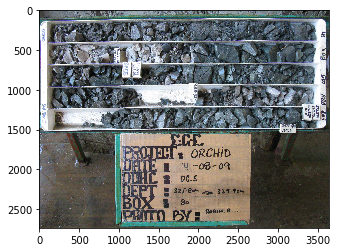

In [727]:
plt.imshow(img)

## Categories

Type_0 – Rows appear nicely positioned in the images with no distortion. These are “straight” trays.
Type_1 – Rows appears slightly bent or misaligned in the image
Type_2 – Image appears slightly distorted
Type_3 – Rows are bent and also distorted
Type_4 – A low aspect ratio exists
Type_5 – A low aspect ratio and also slightly bent.

In [728]:
CATEGORIES = {'Type_0':'straight', 'Type_1':'row_bent', 'Type_2':'img_distorted', 'Type_3':'row_bent_img_distorted', 'Type_4':'low_ar', 'Type_5':'low_ar_and_bent'}
cat_keys = CATEGORIES.keys()
cats = dict((i, o) for i,o in enumerate(cat_keys))
cats

{0: 'Type_0', 1: 'Type_1', 2: 'Type_2', 3: 'Type_3', 4: 'Type_4', 5: 'Type_5'}

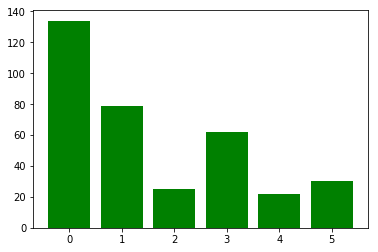

In [729]:
type_0 = train['Type_0'].value_counts()[1]
type_1 = train['Type_1'].value_counts()[1]
type_2 = train['Type_2'].value_counts()[1]
type_3 = train['Type_3'].value_counts()[1]
type_4 = train['Type_4'].value_counts()[1]
type_5 = train['Type_5'].value_counts()[1]
total = train.shape[0]
x = [type_0,type_1,type_2,type_3,type_4,type_5]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, x, color='green')
plt.show()

In [730]:
cats.get(0)

'Type_0'

In [731]:
#looks like we only have one class per image, but why do some have multiple masks?
train_df = train.copy()
train_df['Type_0'] = train_df['Type_0'].astype(str) 
train_df['Type_1'] = train_df['Type_1'].astype(str) 
train_df['Type_2'] = train_df['Type_2'].astype(str) 
train_df['Type_3'] = train_df['Type_3'].astype(str) 
train_df['Type_4'] = train_df['Type_4'].astype(str) 
train_df['Type_5'] = train_df['Type_5'].astype(str) 
train_df['Type_0'] = train_df['Type_0'].replace('1',cats.get(0))
train_df['Type_1'] = train_df['Type_1'].replace('1',cats.get(1))
train_df['Type_2'] = train_df['Type_2'].replace('1',cats.get(2))
train_df['Type_3'] = train_df['Type_3'].replace('1',cats.get(3))
train_df['Type_4'] = train_df['Type_4'].replace('1',cats.get(4))
train_df['Type_5'] = train_df['Type_5'].replace('1',cats.get(5))
train_df[list(cat_keys)] = train_df[list(cat_keys)].replace('0', '')
train_df["Types"] = train_df['Type_0'] +' '+ train_df["Type_1"]+' '+ train_df["Type_2"]+' '+ train_df["Type_3"]+' '+ train_df["Type_4"]+' '+ train_df["Type_5"]
train_df.head()
train_df.Types.unique()

array(['Type_0     ', ' Type_1    ', '  Type_2   ', '   Type_3  ', '    Type_4 ', '     Type_5'],
      dtype=object)

In [732]:
df_types = train[['Type_0', 'Type_1', 'Type_2', 'Type_3', 'Type_4', 'Type_5']].copy()
s2 = df_types.idxmax(axis=1)
s2.head()

0    Type_0
1    Type_0
2    Type_0
3    Type_0
4    Type_0
dtype: object

In [733]:
train['Main_type'] = s2

In [734]:
train.head()

,OutputID,row_1_X_1,row_1_Y_1,row_1_X_2,row_1_Y_2,row_1_X_3,row_1_Y_3,row_1_X_4,row_1_Y_4,row_2_X_1,...,Type_0,Type_1,Type_2,Type_3,Type_4,Type_5,ImageLocation,MaskLocation,id,Main_type
0,Image376_1TPP_4R_PL2.jpg,100,2587,3527,2619,3530,2353,100,2327,100,...,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",0,Type_0
1,Image208_1TPP_3R_MT.jpg,98,879,1529,894,1532,738,100,721,100,...,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",1,Type_0
2,Image212_1TPP_3R_MT.jpg,100,868,1531,886,1535,735,105,715,105,...,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",2,Type_0
3,Image202_1TPP_3R_MT.jpg,101,874,1531,891,1532,749,106,725,103,...,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",3,Type_0
4,Image242_2TPP_4R_MT.JPG,103,1754,2492,1758,2502,1586,108,1582,109,...,1,0,0,0,0,0,https://firebasestorage.googleapis.com/v0/b/la...,"{""Type0_straight_tray"":""https://imagemasks.s3....",4,Type_0


In [735]:
def plot_row(training_path, row, coord_prefix='row', save_to=''):
    """
    Function to plot rows ontop of image
    
    Inputs:
    filepath: A Path object containing the location of the training data. See example. 
    row: A row from the training dataframe

    """
    
    if isinstance (training_path, PosixPath):
        img = plt.imread(training_path/row.OutputID)
    else:
        img = plt.imread(training_path+row.OutputID)
    plt.figure()
    fig = plt.imshow(img)
    ax = fig.axes
    for r in range(1,12):
        patch = []
        for i in range(1,5):
            x = row[f'{coord_prefix}_{r}_X_{i}']
            y = img.shape[0] - row[f'{coord_prefix}_{r}_Y_{i}']
            temp = row[f'{coord_prefix}_{r}_Y_{i}']
            #print(f'x: {x}, y: {y}, img.shape[0]: {img.shape[0]}, row coord: {temp}, img.shape[1]: {img.shape[1]}')
            patch.append([x,y])
        ax.add_patch(patches.Polygon(patch, closed=True, fill=False, linewidth=2,color='red'))
    if save_to:
        plt.savefig(save_to)
        plt.close()

In [736]:
training_path = PATH/'data/train/'
training_path=str(training_path.absolute())+'/'
print(training_path)

/mnt/963GB/Data/Python/Code/unearthed/core_tray/data/data/train/


## Masks
Note masks are per row, where if have 5 of the same type, just has one mask, 2 different types = 2 mask images etc

Here we plot 2 trays where they have 2 masks in the MaskLocation column

In [737]:
train.iloc[32]['OutputID']

'Image353_1TPP_4R_PL2.JPG'

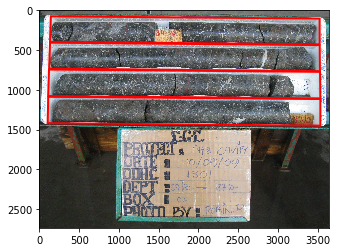

In [738]:
#row 34 in spreadsheet
plot_row(training_path, train.iloc[32])


In [739]:
train.iloc[33]['OutputID']

'Image409_1TPP_5R_MT_FE.JPG'

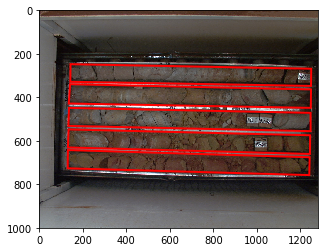

In [740]:
plot_row(training_path, train.iloc[33])

In [741]:
mask_locations = train.iloc[[32]].MaskLocation
mask_locations=mask_locations.to_dict()
mask_locations

{32: '{"Type0_straight_tray":"https://imagemasks.s3.amazonaws.com/41427db232ab7795fb1a3744/cjhjn6knodrvo0702kx037mvj_Type0_straight_tray_mask.png","Type1_bent_tray":"https://imagemasks.s3.amazonaws.com/41427db232ab7795fb1a3744/cjhjn6knodrvo0702kx037mvj_Type1_bent_tray_mask.png"}'}

In [742]:
v = list(mask_locations.values())[0]
d = json.loads(v)
d

{'Type0_straight_tray': 'https://imagemasks.s3.amazonaws.com/41427db232ab7795fb1a3744/cjhjn6knodrvo0702kx037mvj_Type0_straight_tray_mask.png',
 'Type1_bent_tray': 'https://imagemasks.s3.amazonaws.com/41427db232ab7795fb1a3744/cjhjn6knodrvo0702kx037mvj_Type1_bent_tray_mask.png'}

In [743]:
url1 = list(d.values())[0]
url2 = list(d.values())[1]

In [744]:
from IPython.display import Image as ip_image
from IPython.core.display import HTML 

print(f'mask: {url1}')
ip_image(url= url1, width=300, height=300)

mask: https://imagemasks.s3.amazonaws.com/41427db232ab7795fb1a3744/cjhjn6knodrvo0702kx037mvj_Type0_straight_tray_mask.png


In [745]:
image_url = str(train.iloc[[32]].ImageLocation)
ip_image(url= image_url, width=300, height=300)

In [746]:
print(f'mask: {url2}')
ip_image(url= url2, width=300, height=300)

mask: https://imagemasks.s3.amazonaws.com/41427db232ab7795fb1a3744/cjhjn6knodrvo0702kx037mvj_Type1_bent_tray_mask.png


In [747]:
#training file names
trn_ids = list(train.id)
trn_values = list(train.OutputID)
trn_fns=dict(zip(trn_ids, trn_values))
#trn_fns

In [748]:
def check_image_specs(image_list, path):
    #get specifications for all images in image_list in folder path
    widths = []
    heights = []
    for im in image_list:
        w,h=Image.open(path/im).size
        widths.append(w)
        heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    areas = [i*j for i, j in zip(widths, heights)]
    av_area = sum(areas)/len(areas)
    min_area = sorted(areas)[0]
    max_area = sorted(areas)[-1]
    height_to_widths = [i/j for i, j in zip(widths, heights)]
    av_height_to_width = sum(height_to_widths)/len(height_to_widths)
    max_width = max(widths)
    max_height = max(heights)
    print(f'Number of images: {len(trn_fns)}')
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')
    print(f'avg pixels: {av_area}, avg im megapixels: {av_area/1000000}, max pixels: {max(areas)}, min pixels: {min(areas)}')
    print(f'avg av_height_to_width: {av_height_to_width}, max height_to_width: {max(height_to_widths)}, min height_to_widths: {min(height_to_widths)}')
    return areas, max_width, max_height, widths, heights, height_to_widths

In [749]:
areas, max_width, max_height, widths, heights, height_to_widths = check_image_specs(trn_fns.values(),IMG_PATH)

Number of images: 352
avg width: 3448.4261363636365, avg height: 2495.752840909091, max w: 6144, min w: 1024, max h: 4608, min h: 768
avg pixels: 10213429.940340908, avg im megapixels: 10.213429940340909, max pixels: 28274688, min pixels: 786432
avg av_height_to_width: 1.371169839325386, max height_to_width: 1.5334295334295334, min height_to_widths: 1.0765349032800673


(array([98., 28., 43., 86.,  0.,  2., 14., 69.,  0., 12.]),
 array([  786432. ,  3535257.6,  6284083.2,  9032908.8, 11781734.4, 14530560. , 17279385.6, 20028211.2,
        22777036.8, 25525862.4, 28274688. ]),
 <a list of 10 Patch objects>)

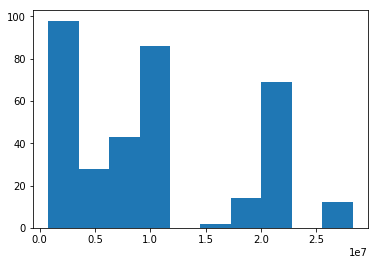

In [750]:
plt.hist(areas)

(array([  8.,   0.,   0.,   0.,  10., 227.,   0.,   0.,  51.,  56.]),
 array([1.07653, 1.12222, 1.16791, 1.2136 , 1.25929, 1.30498, 1.35067, 1.39636, 1.44205, 1.48774, 1.53343]),
 <a list of 10 Patch objects>)

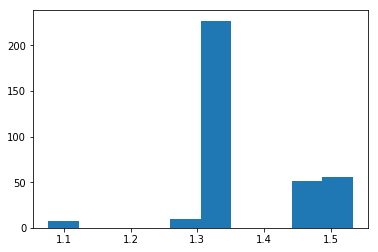

In [751]:
plt.hist(height_to_widths)

(array([51., 21., 27., 28., 42., 86.,  2.,  0., 83., 12.]),
 array([1024., 1536., 2048., 2560., 3072., 3584., 4096., 4608., 5120., 5632., 6144.]),
 <a list of 10 Patch objects>)

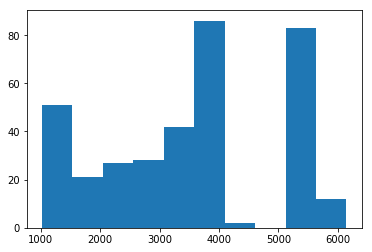

In [752]:
plt.hist(widths)

(array([51., 21., 26., 25., 46., 86.,  2., 83.,  0., 12.]),
 array([ 768., 1152., 1536., 1920., 2304., 2688., 3072., 3456., 3840., 4224., 4608.]),
 <a list of 10 Patch objects>)

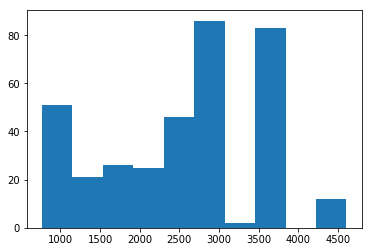

In [753]:
plt.hist(heights)

so we are dealing with moderately regtangular ~1.5 h to width to ~ square images

In [754]:
def store_rotation(df):
    #calaculate how rotated from horizontal the rows are
    for index, row in df.iterrows():
        for n in range(1,12):
            thetas=[]
            if row[f'row_{n}_Y_2'] != 0 and row[f'row_{n}_X_2'] !=0:
                #we first check if there is a tray row
                #how skewed is the orientaion
                o = row[f'row_{n}_Y_1']-row[f'row_{n}_Y_2']
                a = row[f'row_{n}_X_3']-row[f'row_{n}_X_4']
                theta = degrees(atan(o/a))
                df.loc[index, f'theta_{n}']=theta
                #print(f'opp: {o}')
                #print(f'theta: {theta}')
            else:
                df.loc[index, f'theta_{n}']=0
            thetas.append(theta)
        #store the average box rotation
        #TODO would be good to check against max/min box coors
        theta_av=sum(thetas)/len(thetas)
        df.loc[index, 'theta_av']=theta_av
    return df

train = store_rotation(train)

(array([  1.,   0.,   3.,   4.,  44., 145., 132.,  17.,   5.,   1.]),
 array([-6.39883, -5.29943, -4.20003, -3.10063, -2.00123, -0.90183,  0.19757,  1.29697,  2.39637,  3.49577,
         4.59517]),
 <a list of 10 Patch objects>)

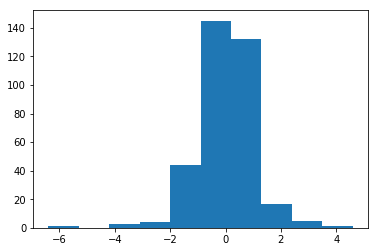

In [755]:
plt.hist(train.theta_av)

In [756]:
train.loc[train['theta_av'].idxmax()]

OutputID                               Image082_1TPP_4R_CB1_FE.jpg
row_1_X_1                                                      331
row_1_Y_1                                                     1835
row_1_X_2                                                     3294
row_1_Y_2                                                     1809
row_1_X_3                                                     3274
row_1_Y_3                                                     1427
row_1_X_4                                                      354
row_1_Y_4                                                     1399
row_2_X_1                                                      365
row_2_Y_1                                                     1382
row_2_X_2                                                     3271
row_2_Y_2                                                     1413
row_2_X_3                                                     3252
row_2_Y_3                                                     

In [757]:
def scale_pad(image_name, path, width, height, save_path=None, save_files=True, method=Image.ANTIALIAS):
    """
    resize image, making square by padding out
    """
    image = Image.open(f'{path}/{image_name}')
    if width>height:
        x=width
        y=width
    else:
        x=height
        y=height
    image.thumbnail((x,y), method)
    #to place it in center of white 'max_size' image
    #offset = (int((max_size[0] - image.size[0]) / 2), int((max_size[1] - image.size[1]) / 2))
    offset = (0, y - image.size[1])
    padding_added = (x - image.size[0], y - image.size[1])
    back = Image.new("RGB", (x,y), "white")
    back.paste(image, offset)
    if save_files:
        #print(f'saving: {save_path}/{image_name}')
        back.save(f'{save_path}/{image_name}')
    return back, padding_added

In [758]:
def pad_to(new_size):
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(elta_h//2))
    new_im = ImageOps.expand(im, padding)
    new_im.show()

In [759]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
def pad_imgs(fnames, widths, heights, path, new_path, save_files=True):
    pads = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(scale_pad, name, path, width, height, new_path, save_files) for name, width, height in zip(fnames, widths, heights)]
    for future in as_completed(futures):
        pads.append(future.result()[1])  
    return pads

In [760]:
def run_pad_test():
    test_name = train['OutputID'].loc[0]
    padded_test, padding_added = scale_pad(image_name=test_name, path=PATH/'data/train/', width=max_width, height=max_width, save_path=None, save_files=False)
    plt.imshow(padded_test)
    print(f'added padding: {padding_added}')

Pad all images and resave - note is possible that test data used by unearthed could have bigger dimensions - not handled yet

Padding all images to max w: 6144 x max w: 6144, keep track of how padded, at end remove padding ammount from bbox coordinates - but too big. Trying downsampling instead.

In [761]:
#maually created this empty folder
PADDED_IMG = PATH/'padded_data/train/'
PADDED_DATA = PATH/'padded_data/'

In [762]:
path=PATH/'data/train/'

#no need to recreate if already made these
pads = pad_imgs(trn_fns.values(), widths, heights, path, PADDED_IMG, save_files=SAVE_PADDED_FILES)
len(pads)
pads[0]

(0, 592)

lets see how padding went

In [763]:
areas, max_width, max_height, widths, heights, height_to_widths = check_image_specs(trn_fns.values(), PADDED_IMG)

Number of images: 352
avg width: 3448.4261363636365, avg height: 3448.4261363636365, max w: 6144, min w: 1024, max h: 6144, min h: 1024
avg pixels: 14278203.119318182, avg im megapixels: 14.278203119318182, max pixels: 37748736, min pixels: 1048576
avg av_height_to_width: 1.0, max height_to_width: 1.0, min height_to_widths: 1.0


In [764]:
len(pads)

352

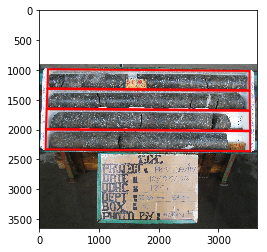

In [765]:
padded_img = str(PADDED_IMG.absolute())+'/'
plot_row(padded_img, train.iloc[32], 'row')

store paddings so dont have to re-caculate from image size

In [766]:
train['width'] = widths
train['height'] = heights
train['pad_width'] = [i[0] for i in pads]
train['pad_height'] = [i[1] for i in pads]

In [767]:
train.head()

,OutputID,row_1_X_1,row_1_Y_1,row_1_X_2,row_1_Y_2,row_1_X_3,row_1_Y_3,row_1_X_4,row_1_Y_4,row_2_X_1,...,theta_7,theta_8,theta_9,theta_10,theta_11,theta_av,width,height,pad_width,pad_height
0,Image376_1TPP_4R_PL2.jpg,100,2587,3527,2619,3530,2353,100,2327,100,...,0.000000,0.000000,0.0,0.0,0.0,-0.687449,3648,3648,0,592
1,Image208_1TPP_3R_MT.jpg,98,879,1529,894,1532,738,100,721,100,...,0.000000,0.000000,0.0,0.0,0.0,-1.159352,1600,1600,0,1876
2,Image212_1TPP_3R_MT.jpg,100,868,1531,886,1535,735,105,715,105,...,0.000000,0.000000,0.0,0.0,0.0,-1.077161,1600,1600,0,400
3,Image202_1TPP_3R_MT.jpg,101,874,1531,891,1532,749,106,725,103,...,0.000000,0.000000,0.0,0.0,0.0,-1.320130,1600,1600,0,1704
4,Image242_2TPP_4R_MT.JPG,103,1754,2492,1758,2502,1586,108,1582,109,...,-0.285406,-0.382125,0.0,0.0,0.0,-0.382125,2592,2592,0,280


## Resize to smaller images

Resize images to 224 x 224

In [768]:
if SAVE_RESIZED_FILES:
    print(f'saving {RESIZE_DIM}x{RESIZE_DIM} resized images')
    resize_imgs(list(trn_fns.values()), targ=RESIZE_DIM, path=PADDED_IMG, new_path=f'../../resized_{RESIZE_DIM}')
    #delete anything already in train
    shutil.rmtree(str(PATH.resolve())+f'/resized_{RESIZE_DIM}/train/')
    #rename the directory to 'train'
    os.rename(str(PATH.resolve())+f'/resized_{RESIZE_DIM}/{RESIZE_DIM}', str(PATH.resolve())+f'/resized_{RESIZE_DIM}/train/')

In [769]:
from os.path import join
#todo need to fix, here manually changed dir 224 to train, couldnt get posix path to join, using string converted absolute path
RESIZED_TRAIN_STR = str(PATH.resolve())+f'/resized_{RESIZE_DIM}/train/'
RESIZED_TRAIN = PATH/f'resized_{RESIZE_DIM}/train/'
RESIZED_STR = str(PATH.resolve())+ f'/resized_{RESIZE_DIM}'
RESIZED_PATH = PATH/f'resized_{RESIZE_DIM}'
print(f'PADDED_DATA: {PADDED_DATA.resolve()}')
print(f'RESIZED_TRAIN: {RESIZED_TRAIN}')
print(f'RESIZED_PATH: {RESIZED_PATH}')

PADDED_DATA: /mnt/nvme_250GB/Data/unearthed/core_tray/padded_data
RESIZED_TRAIN: data/resized_224/train
RESIZED_PATH: data/resized_224


In [770]:
#add columns for scaled box coords
for n in range(1,12):
    for k in range(1,5):
        train[f'scaled_{n}_X_{k}']=0
        train[f'scaled_{n}_Y_{k}']=0

In [771]:
# check the new columns
train.loc[0:10, 'scaled_5_X_1':'scaled_11_X_3']

,scaled_5_X_1,scaled_5_Y_1,scaled_5_X_2,scaled_5_Y_2,scaled_5_X_3,scaled_5_Y_3,scaled_5_X_4,scaled_5_Y_4,scaled_6_X_1,scaled_6_Y_1,...,scaled_10_Y_2,scaled_10_X_3,scaled_10_Y_3,scaled_10_X_4,scaled_10_Y_4,scaled_11_X_1,scaled_11_Y_1,scaled_11_X_2,scaled_11_Y_2,scaled_11_X_3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [772]:
def scale_boxes(df):
    #note we are rounding to nearest pixel
    for index, row in df.iterrows():
        if row['width'] == 0:
            print(f'problem with width data on row {index}')
            scalar = 1
        else:
            scalar = RESIZE_DIM/row['width']
        for n in range(1,12):
            if row[f'row_{n}_Y_2'] != 0 and row[f'row_{n}_X_2'] !=0:
                #we first check if there is a tray row
                #note we ude df.loc as using row[..]= doesnt work inplace
                for j in range(1,5):
                    df.loc[index, f'scaled_{n}_X_{j}']=round(row[f'row_{n}_X_{j}']*scalar)
                    df.loc[index,f'scaled_{n}_Y_{j}']=round(row[f'row_{n}_Y_{j}']*scalar)
            else:
                for k in range(1,5):
                    df.loc[index, f'scaled_{n}_X_{k}']=0
                    df.loc[index,f'scaled_{n}_Y_{k}']==0
        df.loc[index,'scalar']=scalar
    return df

In [773]:
train = scale_boxes(train)

In [774]:
train.to_csv(RESIZED_PATH/f'train_with_labels_scaled_{RESIZE_DIM}.csv', index=False) 

In [775]:
pre_scaled = list(train['row_1_X_2'])
pre_scaled[0:10]

[3527, 1529, 1531, 1531, 2492, 915, 1213, 1721, 1533, 1533]

In [776]:
test_scaled = list(train['scaled_1_X_2'])
test_scaled[0:10]

[217, 214, 214, 214, 215, 200, 212, 215, 215, 215]

In [777]:
# check the scaled data
train.loc[0:10, 'scaled_1_X_1':'scaled_6_X_2']

,scaled_1_X_1,scaled_1_Y_1,scaled_1_X_2,scaled_1_Y_2,scaled_1_X_3,scaled_1_Y_3,scaled_1_X_4,scaled_1_Y_4,scaled_2_X_1,scaled_2_Y_1,...,scaled_5_Y_1,scaled_5_X_2,scaled_5_Y_2,scaled_5_X_3,scaled_5_Y_3,scaled_5_X_4,scaled_5_Y_4,scaled_6_X_1,scaled_6_Y_1,scaled_6_X_2
0,6,159,217,161,217,144,6,143,6,142,...,91,217,94,217,77,7,75,0,0,0
1,14,123,214,125,214,103,14,101,14,100,...,0,0,0,0,0,0,0,0,0,0
2,14,122,214,124,215,103,15,100,15,100,...,0,0,0,0,0,0,0,0,0,0
3,14,122,214,125,214,105,15,102,14,101,...,0,0,0,0,0,0,0,0,0,0
4,9,152,215,152,216,137,9,137,9,136,...,82,218,83,218,68,9,66,9,66,218
5,23,108,200,108,200,95,23,95,23,94,...,56,201,57,201,44,23,43,0,0,0
6,18,131,212,129,212,113,18,117,18,114,...,60,212,57,211,42,17,46,0,0,0
7,13,144,215,145,216,131,12,129,13,129,...,76,217,78,217,64,12,61,12,61,217
8,15,123,215,125,215,105,16,101,16,100,...,0,0,0,0,0,0,0,0,0,0
9,15,124,215,125,215,106,15,102,15,102,...,0,0,0,0,0,0,0,0,0,0


In [778]:
#note height and width are post padding
def get_trn_anno(coord_prefix='scaled'):
    trn_anno_bbs = collections.defaultdict(lambda:[])
    trn_anno_coords = collections.defaultdict(lambda:[])
    trn_row = collections.defaultdict(lambda:[])
    trn_coords = collections.defaultdict(lambda:[])
    trn_anno = collections.defaultdict(lambda:[])
    for index, row in train.iterrows():
        if coord_prefix=='scaled':
            scalar = row['scalar']
            height = RESIZE_DIM
        else:
            height = int(row['height'])
        for n in range(1,12):
            #np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            #we swith the x (bb[0]) and y (bb[1]) coords as we want rows x columns ie rowsxcol for numpy
            
            #print(f'height: {height}')
            #temp=row[f'{coord_prefix}_{n}_Y_1']
            #print(f'Y1: {temp}')
            #check that there are bboxes for this row
            if row[f'row_{n}_Y_2'] != 0 and row[f'row_{n}_X_2'] !=0:
                #how skewed is the orientaion
                o = row[f'{coord_prefix}_{n}_Y_1']-row[f'{coord_prefix}_{n}_Y_2']
                a = row[f'{coord_prefix}_{n}_X_3']-row[f'{coord_prefix}_{n}_X_4']
                theta = degrees(atan(o/a))
                #print(f'opp: {o}')
                #print(f'theta: {theta}')
                y1_from_top = height-row[f'{coord_prefix}_{n}_Y_1']
                y2_from_top = height-row[f'{coord_prefix}_{n}_Y_2']
                y3_from_top = height-row[f'{coord_prefix}_{n}_Y_3']
                y4_from_top = height-row[f'{coord_prefix}_{n}_Y_4']
                #note we use 1,1 and 3,3 for the extremities
                bb = np.array([y1_from_top, row[f'{coord_prefix}_{n}_X_1'], y3_from_top, row[f'{coord_prefix}_{n}_X_3']])
                coords = np.array([y1_from_top, row[f'{coord_prefix}_{n}_X_1'], y2_from_top, row[f'{coord_prefix}_{n}_X_2'],
                                  y3_from_top, row[f'{coord_prefix}_{n}_X_3'], y4_from_top, row[f'{coord_prefix}_{n}_X_4']])
                trn_coords[row['id']].append((coords,row['Main_type']))
                trn_anno[row['id']].append((bb,row['Main_type']))
    return trn_coords, trn_anno

trn_coords, trn_anno = get_trn_anno()

In [779]:
type(trn_coords)

collections.defaultdict

In [780]:
trn_coords[33]

[(array([ 92,  25,  96, 219, 110, 219, 106,  25]), 'Type_1'),
 (array([108,  25, 113, 219, 127, 218, 124,  24]), 'Type_1'),
 (array([127,  24, 131, 218, 146, 218, 142,  23]), 'Type_1'),
 (array([145,  23, 149, 218, 165, 218, 159,  23]), 'Type_1'),
 (array([161,  23, 167, 218, 181, 217, 176,  23]), 'Type_1')]

In [781]:
trn_anno[33]

[(array([ 92,  25, 110, 219]), 'Type_1'),
 (array([108,  25, 127, 218]), 'Type_1'),
 (array([127,  24, 146, 218]), 'Type_1'),
 (array([145,  23, 165, 218]), 'Type_1'),
 (array([161,  23, 181, 217]), 'Type_1')]

Plot the scaled boxes on scaled images

In [782]:
list(trn_coords.values())[32]

[(array([ 61,   9,  62, 216,  82, 216,  80,   8]), 'Type_1'),
 (array([ 81,   8,  83, 217, 103, 217, 101,   7]), 'Type_1'),
 (array([102,   7, 103, 217, 124, 217, 122,   7]), 'Type_1'),
 (array([123,   7, 124, 217, 145, 217, 143,   6]), 'Type_1')]

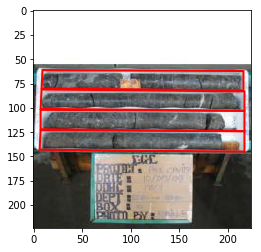

In [783]:
plot_row(RESIZED_TRAIN, train.iloc[32], 'scaled')

In [784]:
#save all padded, resized, masked to sep folder to qc
if SAVE_RESIZED_MASKED:
    for index, row in train.iterrows():
        plot_row(RESIZED_TRAIN, train.iloc[index], 'scaled', save_to=RESIZED_PATH/f'masked/{row["OutputID"]}')


In [785]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [786]:
def bb_hw(a): 
    return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

### Multi class classification

In [787]:
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [788]:
create_dir(PATH/'tmp')

In [789]:
MC_CSV = RESIZED_PATH/'tmp/mc.csv'

In [790]:
#get image id Image225_1TPP_4R_MT.jpg from this dict -returns bbox and category id
trn_anno[0]

[(array([ 65,   6,  80, 217]), 'Type_0'),
 (array([ 82,   6,  96, 217]), 'Type_0'),
 (array([ 99,   6, 113, 217]), 'Type_0'),
 (array([116,   6, 130, 217]), 'Type_0'),
 (array([133,   7, 147, 217]), 'Type_0')]

In [791]:
cats[2]

'Type_2'

In [792]:
list(trn_anno.keys())[1]

1

In [793]:
trn_fns[0]

'Image376_1TPP_4R_PL2.jpg'

In [794]:
for p in trn_anno['Image376_1TPP_4R_PL2.jpg']:
    print(p[1]) 

In [795]:
cats

{0: 'Type_0', 1: 'Type_1', 2: 'Type_2', 3: 'Type_3', 4: 'Type_4', 5: 'Type_5'}

In [796]:
trn_anno[12]

[(array([112,  24, 125, 203]), 'Type_0'),
 (array([125,  24, 137, 203]), 'Type_0'),
 (array([138,  24, 150, 203]), 'Type_0'),
 (array([150,  24, 163, 203]), 'Type_0'),
 (array([163,  24, 177, 203]), 'Type_0')]

note we slaready have category stored in text in file, no need to id

In [797]:
for p in trn_anno[0]:
    print(f'0: {p[0]}, 1: {p[1]}')

0: [ 65   6  80 217], 1: Type_0
0: [ 82   6  96 217], 1: Type_0
0: [ 99   6 113 217], 1: Type_0
0: [116   6 130 217], 1: Type_0
0: [133   7 147 217], 1: Type_0


In [798]:
#for each image we dont want to repeat same labels
mc = [set([p[1] for p in trn_anno[o]]) for o in trn_ids]
#change from list to space sep string
mcs = [' '.join(str(p) for p in o) for o in mc]

In [799]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)
df.head(n=2)

,fn,clas
0,Image376_1TPP_4R_PL2.jpg,Type_0
1,Image208_1TPP_3R_MT.jpg,Type_0


## BBOX


In [800]:
#set up csv files
CLAS_CSV = RESIZED_PATH/'tmp/clas.csv'
MBB_CSV = RESIZED_PATH/'tmp/mbb.csv'

#### timdavidlee notes:

Create Lookups and reference objects

mc - list of items found per image

mcs - list of items found per image, but the ID

id2cat - numeric value to category

cat2id - category to id

In [801]:
cats

{0: 'Type_0', 1: 'Type_1', 2: 'Type_2', 3: 'Type_3', 4: 'Type_4', 5: 'Type_5'}

In [802]:
#for each image we dont want to repeat same labels
mc = [set([p[1] for p in trn_anno[o]]) for o in trn_fns]
cat2id =  {v: k for k, v in cats.items()}
#store ids instead of strings
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [803]:
#get a list of index values for validation set, here we use default of 20%
val_idxs = get_cv_idxs(len(trn_fns))

In [804]:
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)
val_idxs

array([228, 116,  55, 155, 110, 126,  39,  63, 240,  75,  76, 209, 224, 185, 118,  42, 299,  78, 317, 119,
       234,  57, 196,  90, 288,  25, 256,   9,  94,  93, 350, 153, 210,  22, 113, 245,  56, 152,  30,  45,
       101, 114, 278, 137,   5, 219, 341, 339, 202, 167, 325, 158,   3, 109,  72, 307, 343,  46, 314,  73,
       223, 165,  33, 310, 248,  77, 157, 182, 147, 265])

In [805]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [806]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)
df.head(n=2)

,fn,bbox
0,Image376_1TPP_4R_PL2.jpg,65 6 80 217 82 6 96 217 99 6 113 217 116 6 130...
1,Image208_1TPP_3R_MT.jpg,101 14 121 214 124 14 138 215 143 15 160 216


Coords

In [807]:
CBB_CSV = RESIZED_PATH/'tmp/cbb.csv'

In [808]:
cbb = [np.concatenate([p[0] for p in trn_coords[o]]) for o in trn_ids]
cbbs = [' '.join(str(p) for p in o) for o in cbb]

In [809]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'coords': cbbs}, columns=['fn', 'coords'])
df.to_csv(CBB_CSV, index=False)
df.head(n=2)

,fn,coords
0,Image376_1TPP_4R_PL2.jpg,65 6 63 217 80 217 81 6 82 6 80 217 96 217 98 ...
1,Image208_1TPP_3R_MT.jpg,101 14 99 214 121 214 123 14 124 14 121 215 13...
